In [1]:
import io
import numpy as np
import pandas as pd
from tqdm import tqdm
import geopandas as gpd
from pathlib import Path
from itertools import permutations

# Visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

import pandas as pd
import matplotlib
matplotlib.rcParams['font.family'] = 'DejaVu Sans'  # has wide Unicode support

# Modelling
from cf_plus_core import diagnose_inputs, CFPlus, CFPlusConfig, build_fit_predict, validation_curve_df, penalty_report_monthyear

# Base directories
BASE_DIR = Path("/Users/wenlanzhang/PycharmProjects/Mapineq/src/")
DATA_DIR = Path("/Users/wenlanzhang/Downloads/PhD_UCL/Data/Oxford")

# Load Data

##  Meta SCI - VE missing
Source: https://data.humdata.org/dataset/social-connectedness-index

In [2]:
df_SCI = pd.read_csv(DATA_DIR/f"Migration/Excess/countries-countries-fb-social-connectedness-index-october-2021.tsv", sep="\t") 
# df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_SCI

,user_loc,fr_loc,scaled_sci
0,AE,AE,1117179
1,AE,AG,5488
2,AE,AL,2101
3,AE,AM,3580
4,AE,AO,2326
...,...,...,...
34220,ZW,XK,262
34221,ZW,YT,1650
34222,ZW,ZA,366466
34223,ZW,ZM,196035


In [3]:
# Collect all unique country codes from SCI
sci_countries = set(df_SCI["user_loc"].unique()) | set(df_SCI["fr_loc"].unique())

# Collect all unique country codes from migration data
migration_countries = set(df["country_from"].unique()) | set(df["country_to"].unique())

# Countries in SCI but not in migration
missing_in_migration = sci_countries - migration_countries

# Countries in migration but not in SCI
missing_in_sci = migration_countries - sci_countries

print("Countries in SCI but missing in migration:")
print(sorted(missing_in_migration))

print("\nCountries in migration but missing in SCI:")
print(sorted(missing_in_sci))

NameError: name 'df' is not defined

## Meta Migration 

In [2]:
df = pd.read_csv(DATA_DIR/f"Migration/international_migration_flow.csv") 
df['year'] = pd.to_datetime(df['migration_month']).dt.year
df['month'] = pd.to_datetime(df['migration_month']).dt.month
df["migration_month"] = pd.to_datetime(df["migration_month"])

# Unique list from both columns
unique_countries = pd.unique(df[["country_from", "country_to"]].values.ravel())

df

,country_from,country_to,migration_month,num_migrants,year,month
0,AD,AE,2019-01-01,12,2019,1
1,AD,AE,2019-02-01,2,2019,2
2,AD,AE,2019-03-01,1,2019,3
3,AD,AE,2019-04-01,7,2019,4
4,AD,AE,2019-05-01,0,2019,5
...,...,...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138,2022,8
1563150,ZW,ZM,2022-09-01,162,2022,9
1563151,ZW,ZM,2022-10-01,149,2022,10
1563152,ZW,ZM,2022-11-01,104,2022,11


In [3]:
# Keep only what we need and rename to the model’s expected names
df_flow = (df
      .rename(columns={
          "country_from": "orig",
          "country_to": "dest",
          # "migration_month": "month",
          "num_migrants": "flow"
      })
      [["orig", "dest", "migration_month", "flow"]].copy()).rename(columns={
          "migration_month": "month"      })

# Make sure month is monthly datetime (month-start)
# df_flow["month"] = pd.to_datetime(df["month"]).dt.to_period("M").dt.to_timestamp()

# Clean types
df_flow["orig"] = df_flow["orig"].astype(str).str.upper()
df_flow["dest"] = df_flow["dest"].astype(str).str.upper()
df_flow["flow"] = pd.to_numeric(df_flow["flow"], errors="coerce").fillna(0).clip(lower=0).astype(int)

# If there are accidental duplicates (same orig-dest-month), aggregate
# df_flow = (df_flow.groupby(["orig", "dest", "month"], as_index=False)["flow"].sum())

df_flow

,orig,dest,month,flow
0,AD,AE,2019-01-01,12
1,AD,AE,2019-02-01,2
2,AD,AE,2019-03-01,1
3,AD,AE,2019-04-01,7
4,AD,AE,2019-05-01,0
...,...,...,...,...
1563149,ZW,ZM,2022-08-01,138
1563150,ZW,ZM,2022-09-01,162
1563151,ZW,ZM,2022-10-01,149
1563152,ZW,ZM,2022-11-01,104


## Country alpha2/3

In [4]:
df_country = pd.read_csv(DATA_DIR/f"all.csv") 
df_country = df_country[['name', 'alpha-2', 'alpha-3', 
                         'region', 'sub-region']]

df_country = df_country[df_country["alpha-2"].isin(unique_countries)]
df_country

,name,alpha-2,alpha-3,region,sub-region
0,Afghanistan,AF,AFG,Asia,Southern Asia
2,Albania,AL,ALB,Europe,Southern Europe
3,Algeria,DZ,DZA,Africa,Northern Africa
5,Andorra,AD,AND,Europe,Southern Europe
6,Angola,AO,AGO,Africa,Sub-Saharan Africa
...,...,...,...,...,...
240,"Venezuela, Bolivarian Republic of",VE,VEN,Americas,Latin America and the Caribbean
241,Viet Nam,VN,VNM,Asia,South-eastern Asia
246,Yemen,YE,YEM,Asia,Western Asia
247,Zambia,ZM,ZMB,Africa,Sub-Saharan Africa


## Population 
Source: World Bank  
https://data.worldbank.org/indicator/SP.POP.TOTL

In [5]:
df_pop = pd.read_csv(DATA_DIR/f"Migration/Excess/API_SP.POP.TOTL_DS2_en_csv_v2_710977.csv") 
df_pop = df_pop[['Country Code', '2019', '2020', '2021', '2022']]
df_pop

,Country Code,2019,2020,2021,2022
0,ABW,109203.0,108587.0,107700.0,107310.0
1,AFE,675950189.0,694446100.0,713090928.0,731821393.0
2,AFG,37856121.0,39068979.0,40000412.0,40578842.0
3,AFW,463365429.0,474569351.0,485920997.0,497387180.0
4,AGO,32375632.0,33451132.0,34532429.0,35635029.0
...,...,...,...,...,...
261,XKX,1788891.0,1790151.0,1786079.0,1768096.0
262,YEM,35111408.0,36134863.0,37140230.0,38222876.0
263,ZAF,59587885.0,60562381.0,61502603.0,62378410.0
264,ZMB,18513839.0,19059395.0,19603607.0,20152938.0


In [6]:
# Make a mapping dictionary: alpha-3 → alpha-2
alpha_map = dict(zip(df_country["alpha-3"], df_country["alpha-2"]))

# Map alpha-3 to alpha-2
df_pop["Country Code"] = df_pop["Country Code"].map(alpha_map)

# Drop rows where mapping failed (NaN values in Country Code)
df_pop = df_pop.dropna(subset=["Country Code"]).reset_index(drop=True)

df_pop

,Country Code,2019,2020,2021,2022
0,AF,37856121.0,39068979.0,40000412.0,40578842.0
1,AO,32375632.0,33451132.0,34532429.0,35635029.0
2,AL,2854191.0,2837849.0,2811666.0,2777689.0
3,AD,76474.0,77380.0,78364.0,79705.0
4,AE,9445785.0,9401038.0,9575152.0,10074977.0
...,...,...,...,...,...
173,WS,209780.0,211944.0,213779.0,215261.0
174,YE,35111408.0,36134863.0,37140230.0,38222876.0
175,ZA,59587885.0,60562381.0,61502603.0,62378410.0
176,ZM,18513839.0,19059395.0,19603607.0,20152938.0


In [7]:
# Convert to long format
df_pop_long = df_pop.melt(id_vars=["Country Code"], 
                  var_name="Year", 
                  value_name="Population")

# After melting into long format (df_long)
df_pop_long = df_pop_long.rename(columns={
    "Country Code": "iso3",
    "Year": "year",
    "Population": "population"
})

df_pop_long

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


## Prep

In [8]:
# Get unique country codes from both datasets
pop_codes = set(df_pop["Country Code"].unique())
flow_codes = set(df_flow["orig"].unique()) | set(df_flow["dest"].unique())

# Find differences
missing_in_pop = flow_codes - pop_codes
missing_in_flow = pop_codes - flow_codes

print("✅ Country codes in flow but missing in pop:")
print(missing_in_pop if missing_in_pop else "None")

print("\n✅ Country codes in pop but missing in flow:")
print(missing_in_flow if missing_in_flow else "None")

✅ Country codes in flow but missing in pop:
{'TW', 'NAN', 'XK'}

✅ Country codes in pop but missing in flow:
None


In [9]:
print("✅ Before cleaning:", len(df_flow))

# Allowed country codes (from df_pop)
valid_codes = set(df_pop["Country Code"].unique())

# Keep only rows where both orig and dest are in df_pop
df_flow = df_flow[
    df_flow["orig"].isin(valid_codes) & df_flow["dest"].isin(valid_codes)
].copy()

print("✅ After cleaning:", len(df_flow))

✅ Before cleaning: 1563154
✅ After cleaning: 1511698


## Smaller Set 

### Latin America countries

In [13]:
# selected_countries = ["VE", "CL", "US", "EC", "CO"]  # 2-letter ISO codes

selected_countries = [
    # South America
    'AR',  # Argentina
    'BO',  # Bolivia
    'BR',  # Brazil
    'CL',  # Chile
    'CO',  # Colombia
    'EC',  # Ecuador
    'GY',  # Guyana
    'PY',  # Paraguay
    'PE',  # Peru
    'SR',  # Suriname
    'UY',  # Uruguay
    'VE',  # Venezuela

    # # Central America
    # 'BZ',  # Belize
    'CR',  # Costa Rica
    # 'SV',  # El Salvador
    # 'GT',  # Guatemala
    # 'HN',  # Honduras
    'NI',  # Nicaragua
    'PA',  # Panama

    # Mexico
    'MX',  # Mexico

    # Caribbean (Latin)
    'CU',  # Cuba
    'DO',  # Dominican Republic
    'PR',  # Puerto Rico (US territory but culturally Latin)
    'HT',  # Haiti (French/Creole-speaking, sometimes included)

    # Manually add US & CA
    'US','CA','ES'
]

# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
5,AR,2019,44973465.0
21,BO,2019,11671386.0
22,BR,2019,207455459.0
28,CA,2019,37618495.0
30,CL,2019,19197744.0
...,...,...,...
666,PY,2022,6760464.0
681,SR,2022,623164.0
700,UY,2022,3390913.0
701,US,2022,334017321.0


### European countries

In [11]:
selected_countries = [
    # European Union (EU) - Northern Europe
    'DK',  # Denmark
    'EE',  # Estonia
    'FI',  # Finland
    'IE',  # Ireland
    'LV',  # Latvia
    'LT',  # Lithuania
    'SE',  # Sweden

    # European Union (EU) - Western Europe
    'AT',  # Austria
    'BE',  # Belgium
    'FR',  # France
    'DE',  # Germany
    'LU',  # Luxembourg
    'NL',  # Netherlands

    # European Union (EU) - Southern Europe
    'HR',  # Croatia
    'CY',  # Cyprus
    'GR',  # Greece
    'IT',  # Italy
    'MT',  # Malta
    'PT',  # Portugal
    'SI',  # Slovenia
    'ES',  # Spain

    # # European Union (EU) - Central & Eastern Europe
    # 'BG',  # Bulgaria
    # 'CZ',  # Czechia (Czech Republic)
    # 'HU',  # Hungary
    # 'PL',  # Poland
    # 'RO',  # Romania
    # 'SK',  # Slovakia

    # # European Union (EU) - Recent Members
    # 'HR',  # Croatia (joined 2013)
]
# 1️⃣ Filter population data
pops_filtered = df_pop_long[df_pop_long['iso3'].isin(selected_countries)].copy()

# Optional: check
print("Filtered population data:")
pops_filtered

Filtered population data:


,iso3,year,population
8,AT,2019,8879920.0
11,BE,2019,11488980.0
39,CY,2019,1286671.0
41,DE,2019,83092962.0
43,DK,2019,5814422.0
...,...,...,...
642,MT,2022,531113.0
654,NL,2022,17700982.0
665,PT,2022,10434332.0
683,SI,2022,2112076.0


## Set flow 

In [10]:
# For all
flows_filtered = df_flow
pops_filtered = df_pop_long

In [14]:
# # Filter selected flows data 
# # both orig and dest must be in selected countries
# flows_filtered = df_flow[
#     df_flow['orig'].isin(selected_countries) & df_flow['dest'].isin(selected_countries)
# ].copy()

# print("\nFiltered flow data:")
# flows_filtered


Filtered flow data:


,orig,dest,month,flow
52750,AR,BO,2019-01-01,3325
52751,AR,BO,2019-02-01,3275
52752,AR,BO,2019-03-01,2686
52753,AR,BO,2019-04-01,2089
52754,AR,BO,2019-05-01,2084
...,...,...,...,...
1493597,VE,UY,2022-08-01,122
1493598,VE,UY,2022-09-01,121
1493599,VE,UY,2022-10-01,161
1493600,VE,UY,2022-11-01,149


In [15]:
# df_flow.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/df_flow.csv", index=False)

# Check Data

In [11]:
report = diagnose_inputs(df_flow, df_pop_long)
report

,value
flows_min_month,2019-01-01 00:00:00
flows_max_month,2022-12-01 00:00:00
n_rows_flows,1511698
n_pairs,31496
rows_year_2019,377921
rows_year_2020,377923
rows_year_2021,377926
rows_year_2022,377928
pop_cols,"iso3,population,year"
n_countries_flows,178


In [12]:
# Optional: Sanity checks that avoid NaNs and bad splits

print(df_flow['month'].min(), df_flow['month'].max())
print(df_pop_long[['iso3','year']].drop_duplicates().head())

2019-01-01 00:00:00 2022-12-01 00:00:00
  iso3  year
0   AF  2019
1   AO  2019
2   AL  2019
3   AD  2019
4   AE  2019


#  Counterfactual

In [13]:
# Selected data
flows = flows_filtered
pops = pops_filtered

# Full data
# flows = df_flow
# pops = df_pop_long

# Sample data
# flows = pd.read_csv("flows_sample.csv")     # orig, dest, month, flow
# pops  = pd.read_csv("pops_sample.csv")      # iso3, year, population

pops

,iso3,year,population
0,AF,2019,37856121.0
1,AO,2019,32375632.0
2,AL,2019,2854191.0
3,AD,2019,76474.0
4,AE,2019,9445785.0
...,...,...,...
707,WS,2022,215261.0
708,YE,2022,38222876.0
709,ZA,2022,62378410.0
710,ZM,2022,20152938.0


| Parameter                | Type / Example                          |                                         Default | What it controls                                                                           | When to change                                                                                     |
| ------------------------ | --------------------------------------- | ----------------------------------------------: | ------------------------------------------------------------------------------------------ | -------------------------------------------------------------------------------------------------- |
| `train_end`              | `str` date, e.g. `"2021-12-01"`         |                                  `"2021-12-01"` | Last month included in training (inclusive).                                               | Set to the end of your intended training window. Ensure your data covers it.                       |
| `val_start`              | `str` date, e.g. `"2021-07-01"`         |                                  `"2021-07-01"` | Start of the **validation slice** inside training, used to pick `alpha`.                   | Use a late subset (last 6–12 months of training). If too short, the code falls back automatically. |
| `baseline_years`         | `tuple[int]`, e.g. `(2019, 2020, 2021)` |                                       `(2019,)` | Years used to compute the month‑of‑year seasonal profile `S_m`.                            | If 2019 is sparse, include additional years (e.g., 2019–2021).                                     |
| `alphas`                 | `tuple[float]`, e.g. `(1e-6, …, 1.0)`   | `(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0)` | L2 regularization strengths searched on the validation slice.                              | If you see convergence warnings or overfit, include larger values (e.g., `1.0, 2.0`).              |
| `standardize_continuous` | `bool`                                  |                                          `True` | Whether to standardize continuous features (`log_pop_o`, `log_pop_d`, `H_t`, `covid_idx`). | Leave `True` unless you have pre‑standardized inputs.                                              |
| `use_external_covid`     | `bool`                                  |                                         `False` | Whether to include an external monthly COVID index (`covid_df['covid_idx']`).              | Set `True` if you supply `covid_df`; otherwise keep `False`.                                       |
| `max_iter`               | `int`                                   |                                         `20000` | Max iterations for the Poisson optimizer (LBFGS).                                          | Increase if you still see `ConvergenceWarning`.                                                    |
| `tol`                    | `float`                                 |                                          `1e-7` | Tolerance for optimizer convergence.                                                       | Tighten if you want stricter convergence; loosen for speed.                                        |
| `progress`               | `bool`                                  |                                          `True` | Shows a `tqdm` progress bar for the alpha grid.                                            | Set `False` for quiet logs (e.g., batch runs).                                                     |


Practical tips (to avoid the common pain points)
- Codecs match: Make sure df_flow['orig','dest'] and df_pop_long['iso3'] use the same code system (ISO3 if you follow the write‑up). If yours are ISO2, convert one side.
- Seasonality baseline: If baseline years are empty or zero, the code falls back to a flat seasonal profile (S_m ≡ 1) so H_t stays finite.
- Population gaps: Missing population values get imputed with the year‑median across countries (then log‑transformed). You can swap in your preferred population series.
- Convergence: Remaining ConvergenceWarnings are usually benign, but you can raise max_iter, and/or bias to larger alphas.
- External shocks: If you pass an external covid_df, it will be added as another global signal alongside the learned H_t. If you prefer to use only the external index, set baseline_years=() and overwrite H_t with zeros in a small wrapper.

In [14]:
# 1) Fit
cfg = CFPlusConfig(train_end="2022-12-01",  # end of training window (inclusive)
                   val_start="2021-07-01",  # late-slice inside training for alpha selection
                   alphas=(1e-6,1e-5,1e-4,1e-3), 
                     # alphas=(1e-6,1e-5,1e-4,1e-3,1e-2,5e-2,1e-1,5e-1,1.0),
                   max_iter=20000, tol=1e-7,       # convergence knobs
                   progress=False)
cf, design, pred = build_fit_predict(flows, pops, cfg)

# design - analysis-ready data
# pred - prediction output

pred

/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12388 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(
/opt/miniconda3/envs/geo_env_LLM/lib/python3.10/site-packages/sklearn/linear_model/_glm/glm.py:285: ConvergenceWarning: lbfgs failed to converge after 12414 iteration(s) (status=1):
STOP: TOTAL NO. OF F,G EVALUATIONS EXCEEDS LIMIT

You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result(


,orig,dest,month,flow,mu_hat,excess_pct
0,AD,AE,2019-01-01,12.0,5.775084,1.077892
1,AD,AE,2019-02-01,2.0,6.478407,-0.691282
2,AD,AE,2019-03-01,1.0,7.266573,-0.862384
3,AD,AE,2019-04-01,7.0,6.926627,0.010593
4,AD,AE,2019-05-01,0.0,6.662004,-1.000000
...,...,...,...,...,...,...
1511803,ZW,ZM,2022-08-01,138.0,131.921708,0.046075
1511804,ZW,ZM,2022-09-01,162.0,123.823438,0.308315
1511805,ZW,ZM,2022-10-01,149.0,153.194337,-0.027379
1511806,ZW,ZM,2022-11-01,104.0,123.159540,-0.155567


In [15]:
# 2) Validation curve (no re-fitting)
vc = validation_curve_df(cf)
print(vc)
print("Best alpha:", cf.best_alpha_)

      alpha    val_mae
0  0.000001  50.332203
1  0.000010  50.367229
2  0.000100  50.808920
3  0.001000  56.115400
Best alpha: 1e-06


In [16]:
# 3) Penalty + deviance (once)
rep = penalty_report_monthyear(cf, return_deviance=True,
                               flows_df=flows, pop_df=pops)
print(rep)

{'alpha': 1e-06, 'groups_sq': {'||theta||^2': 66605.61491827412, '||month_year||^2': 5.807458519107363, 'beta_log_pop_o': 0.0029744627537572946, 'beta_log_pop_d': 0.0029744627537572946}, 'sum_sq_all': 66611.42832571873, 'penalty_value_sklearn': 0.033305714162859365, 'penalty_value_alpha_sum': 0.06661142832571873, 'continuous_coefs_original_scale': {'beta_log_pop_o': 0.054538635422581805, 'beta_log_pop_d': 0.054538635422581805}, 'train_poisson_deviance': 41601190.37187343, 'train_objective_value': 41601190.40517914}


In [17]:
pred[pred['flow'] >= 1000].sort_values(by="excess_pct", ascending=False) 

,orig,dest,month,flow,mu_hat,excess_pct
573139,HK,KH,2020-08-01,2215.0,63.986187,33.616847
1407314,UG,OM,2019-03-01,3677.0,123.957294,28.663442
573140,HK,KH,2020-09-01,2898.0,97.745772,28.648341
708595,KG,IN,2020-08-01,2095.0,76.823956,26.270139
431958,ET,SY,2019-07-01,5177.0,222.227520,22.295945
...,...,...,...,...,...,...
1456255,VN,JP,2021-08-01,1003.0,10164.218625,-0.901321
1456259,VN,JP,2021-12-01,1014.0,10276.353477,-0.901327
1456260,VN,JP,2022-01-01,1363.0,14110.070479,-0.903402
1394840,UA,DE,2019-09-01,1062.0,11377.004917,-0.906654


# Export / Readin 

In [2]:
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv", index=False)
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv", index=False)
# pred.to_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_ALL.csv", index=False)

# pred_EU = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_EU.csv") 
# pred_LA = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_LA.csv") 
pred_ALL = pd.read_csv("/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/4plot/pred_CF_ALL.csv") 

In [18]:
# Single corridor
corr = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
corr

,orig,dest,month,flow,mu_hat,excess_pct
288288,CL,US,2019-01-01,520.0,1790.269008,-0.709541
288289,CL,US,2019-02-01,671.0,2008.298375,-0.665886
288290,CL,US,2019-03-01,938.0,2252.628976,-0.583598
288291,CL,US,2019-04-01,667.0,2147.245987,-0.689370
288292,CL,US,2019-05-01,684.0,2065.213222,-0.668799
288293,CL,US,2019-06-01,928.0,2171.955900,-0.572735
288294,CL,US,2019-07-01,974.0,2423.341874,-0.598076
288295,CL,US,2019-08-01,1111.0,2329.643381,-0.523103
288296,CL,US,2019-09-01,701.0,2167.726583,-0.676620
288297,CL,US,2019-10-01,664.0,2185.332776,-0.696156


# Plot

## Training 

1. Validation curve (α vs MAE):
- Shows how the ridge penalty affects out-of-sample fit.
- Lets you justify your chosen α.
2. Observed vs Predicted (train + validation slices):
- Demonstrates calibration.
- Lets reviewers see if there’s systematic bias.
3. Residual distribution (excess_pct or z):
- Shows error structure, skew, and overdispersion.
- Important for arguing your z-scores are meaningful.
4. Penalty composition:
- Explains where the regularization bites (almost all on pair FEs).
- Tells the story that corridor heterogeneity dominates the fit.
5. Penalty report values (deviance, objective, coefficient magnitudes):
- Documents the actual training objective.
- Lets you check that α isn’t driving continuous coefs to zero.

In [4]:
from CF_result import (
    plot_validation_curve, plot_obs_vs_pred_masks, plot_residual_histogram,
    plot_penalty_composition, save_all_diagnostics,
    use_nature_style
)

from CF_result import (
    export_validation_curve, export_preds_with_masks,
    export_penalty_report, export_residuals_only
    )

use_nature_style()

preds = pred_ALL
pred = pred_ALL

In [33]:
# # Save & Check plot

# # mpl.rcParams["axes.prop_cycle"] = mpl.cycler(color=["#1b9e77", "#d95f02", "#7570b3", "#e7298a"])
# plot_validation_curve(cf, save_path="validation_curve.png")
# plot_obs_vs_pred_masks(preds, cf.fit_mask_, save_path="obs_vs_pred_fit.png",
#                        title="Observed vs predicted (fit slice)", hexbin=False)
# plot_obs_vs_pred_masks(preds, cf.val_mask_, save_path="obs_vs_pred_val.png",
#                        title="Observed vs predicted (validation slice)", hexbin=True)
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 100), logy=True, save_path="excess_hist.png")
# rep = penalty_report_monthyear(cf, return_deviance=True, flows_df=flows, pop_df=pops)
# plot_penalty_composition(rep, save_path="penalty_composition.png")

'penalty_composition.png'

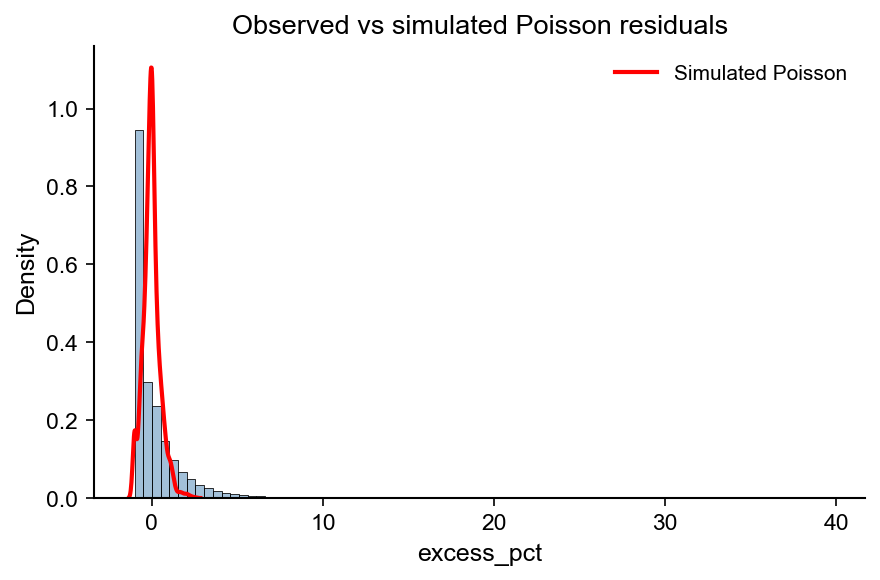

In [37]:
# With Simulation
sim = []
for mu in preds["mu_hat"].sample(2000, random_state=1):  # sample to save time
    y_sim = np.random.poisson(mu)
    sim.append((y_sim - mu) / max(mu, 1.0))
sim = np.array(sim)

# histogram your observed residuals
sns.histplot(preds["excess_pct"], bins=80, stat="density", color="steelblue", alpha=0.5)

# overlay KDE of simulated Poisson excess_pct
sns.kdeplot(sim, color="red", lw=2, label="Simulated Poisson")

plt.legend()
plt.xlabel("excess_pct")
plt.ylabel("Density")
plt.title("Observed vs simulated Poisson residuals")
plt.tight_layout()
plt.savefig('Observed_predicted.png', bbox_inches="tight")
plt.show()

In [29]:
# # ---------- Residual histogram with optional Poisson simulation ----------
# def plot_residual_histogram(preds_df, *, col="excess_pct", bins=80, xlim=None,
#                             logy=False, save_path="residual_hist.png", title=None,
#                             overlay_poisson=False, n_sim=2000, random_state=1):
#     """
#     Histogram of residual metrics. Default 'excess_pct'. 
#     For standardized residuals use col='z_std_jk'.

#     If overlay_poisson=True, simulate Poisson flows given mu_hat
#     and overlay the distribution of simulated residuals as a KDE line.
#     """
#     if col not in preds_df.columns:
#         raise ValueError(f"Column '{col}' not found in preds_df.")
#     x = pd.to_numeric(preds_df[col], errors="coerce").dropna().values

#     plt.figure(figsize=(6,4), dpi=150)
#     # observed histogram
#     sns.histplot(x, bins=bins, stat="density", color="steelblue", alpha=0.5, label="Observed")

#     if overlay_poisson:
#         if "mu_hat" not in preds_df.columns:
#             raise ValueError("Need 'mu_hat' in preds_df to simulate Poisson residuals.")
#         rng = np.random.default_rng(seed=random_state)
#         mus = preds_df["mu_hat"].dropna()
#         mus = mus.sample(min(n_sim, len(mus)), random_state=random_state).values
#         sim = []
#         for mu in mus:
#             y_sim = rng.poisson(mu)
#             sim.append((y_sim - mu) / max(mu, 1.0))
#         sim = np.array(sim)
#         # overlay KDE of simulated residuals
#         sns.kdeplot(sim, color="red", lw=2, label="Simulated Poisson")

#     if xlim is not None:
#         plt.xlim(xlim)
#     if logy:
#         plt.yscale("log")
#     if col.lower().startswith("z"):
#         plt.axvline(0, linestyle="--")
#         plt.axvline(2, linestyle=":")
#         plt.axvline(-2, linestyle=":")
#     plt.xlabel(col)
#     plt.ylabel("Density" if overlay_poisson else "Count")
#     plt.title(title or f"Distribution of {col}")
#     if overlay_poisson:
#         plt.legend()
#     plt.tight_layout()
#     plt.savefig(save_path, bbox_inches="tight")
#     plt.close()
#     return save_path

# # Normal histogram only
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 10),
#                         logy=True, save_path="resid_hist.png")

# # With simulated Poisson overlay
# plot_residual_histogram(preds, col="excess_pct", xlim=(-1, 10),
#                         logy=True, overlay_poisson=True,
#                         n_sim=2000, save_path="resid_hist_overlay.png")


'resid_hist_overlay.png'

In [35]:
# # Export .csv for plot in R

# # Export validation curve
# vc = export_validation_curve(cf, "val_curve.csv")

# # Export predictions (+ masks so you can filter in R/ggplot)
# preds_out = export_preds_with_masks(cf, preds, "preds_with_masks.csv")

# # Export penalty report (JSON + bar-chart CSV)
# rep, groups = export_penalty_report(cf, flows, pops,
#                                     path_json="penalty_report.json",
#                                     path_csv="penalty_groups.csv")

# # Export residuals-only table (for a quick histogram elsewhere)
# res = export_residuals_only(preds, col="excess_pct", path_csv="residuals.csv")

## Different model 

In [ ]:
df1_plot = pred_EU.dropna(subset=["excess_pct"])
df2_plot = pred_LA.dropna(subset=["excess_pct"])

plt.hist(df1_plot["excess_pct"], bins=20, alpha=0.5, label="EU", edgecolor="black")
plt.hist(df2_plot["excess_pct"], bins=20, alpha=0.5, label="LA", edgecolor="black")

plt.xlabel("Excess %")
plt.ylabel("Frequency")
plt.title("Distribution Comparison of Excess Percentage")
plt.xlim(-1.5, 6)

plt.legend()
plt.show()

## Result 

### All

In [5]:
df_global = pred.groupby("month", as_index=False).agg(
    flow_obs=("flow","sum"),
    flow_hat=("mu_hat","sum")
)
df_global["excess_pct"] = (df_global["flow_obs"] - df_global["flow_hat"]) / df_global["flow_hat"]
df_global

,month,flow_obs,flow_hat,excess_pct
0,2019-01-01,2129639.0,2.129690e+06,-2.405391e-05
1,2019-02-01,2388998.0,2.389056e+06,-2.439599e-05
2,2019-03-01,2679640.0,2.679710e+06,-2.615414e-05
3,2019-04-01,2554307.0,2.554347e+06,-1.577442e-05
4,2019-05-01,2456583.0,2.456762e+06,-7.275737e-05
5,2019-06-01,2583701.0,2.583742e+06,-1.587458e-05
6,2019-07-01,2882614.0,2.882789e+06,-6.064752e-05
7,2019-08-01,2771315.0,2.771326e+06,-3.907547e-06
8,2019-09-01,2578673.0,2.578711e+06,-1.467887e-05
9,2019-10-01,2599599.0,2.599655e+06,-2.155846e-05


Text(0.5, 0, 'Month')

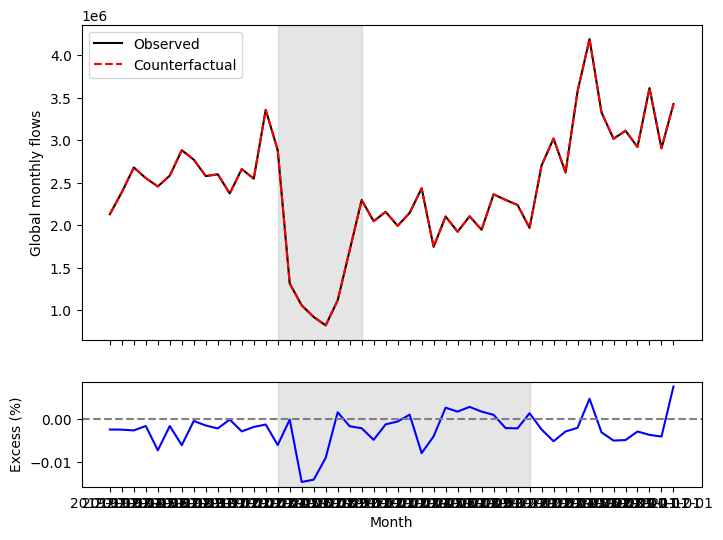

In [6]:
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,6), 
#                                sharex=True, 
#                                gridspec_kw={'height_ratios':[3,1]})

# # Main line chart
# ax1.plot(df_global["month"], df_global["flow_obs"], label="Observed", color="black")
# ax1.plot(df_global["month"], df_global["flow_hat"], label="Counterfactual", linestyle="--", color="red")

# # COVID shading
# ax1.axvspan("2020-03-01", "2020-10-01", color="grey", alpha=0.2)

# ax1.set_ylabel("Global monthly flows")
# ax1.legend()

# # Excess % subplot
# ax2.plot(df_global["month"], df_global["excess_pct"]*100, color="blue")
# ax2.axhline(0, linestyle="--", color="grey")
# ax2.axvspan("2020-03-01", "2021-12-01", color="grey", alpha=0.2)

# ax2.set_ylabel("Excess (%)")
# ax2.set_xlabel("Month")


In [9]:
# g = pred.groupby("month", as_index=False).agg(obs=("flow","sum"), hat=("mu_hat","sum"))
# g["s"] = g["obs"] / g["hat"]
# pred = pred.merge(g[["month","s"]], on="month", how="left")
# pred["mu_hat_cal"] = pred["mu_hat"] * pred["s"]
# pred

,orig,dest,month,flow,mu_hat,excess_pct,s,mu_hat_cal
0,AD,AE,2019-01-01,12.0,5.775084,1.077892,0.999976,5.774945
1,AD,AE,2019-02-01,2.0,6.478407,-0.691282,0.999976,6.478249
2,AD,AE,2019-03-01,1.0,7.266573,-0.862384,0.999974,7.266383
3,AD,AE,2019-04-01,7.0,6.926627,0.010593,0.999984,6.926517
4,AD,AE,2019-05-01,0.0,6.662004,-1.000000,0.999927,6.661519
...,...,...,...,...,...,...,...,...
1511803,ZW,ZM,2022-08-01,138.0,131.921708,0.046075,0.999951,131.915270
1511804,ZW,ZM,2022-09-01,162.0,123.823438,0.308315,0.999971,123.819883
1511805,ZW,ZM,2022-10-01,149.0,153.194337,-0.027379,0.999963,153.188734
1511806,ZW,ZM,2022-11-01,104.0,123.159540,-0.155567,0.999959,123.154544


In [10]:
# G = pred.groupby("month", as_index=False).agg(
#     obs=("flow","sum"),
#     hat_cal=("mu_hat_cal","sum"),
#     pos_excess=("flow","sum")  # temp placeholder
# )
# G

,month,obs,hat_cal,pos_excess
0,2019-01-01,2129639.0,2129639.0,2129639.0
1,2019-02-01,2388998.0,2388998.0,2388998.0
2,2019-03-01,2679640.0,2679640.0,2679640.0
3,2019-04-01,2554307.0,2554307.0,2554307.0
4,2019-05-01,2456583.0,2456583.0,2456583.0
5,2019-06-01,2583701.0,2583701.0,2583701.0
6,2019-07-01,2882614.0,2882614.0,2882614.0
7,2019-08-01,2771315.0,2771315.0,2771315.0
8,2019-09-01,2578673.0,2578673.0,2578673.0
9,2019-10-01,2599599.0,2599599.0,2599599.0


In [11]:
# # recompute excess metrics
# tmp = pred.assign(
#     pos=lambda x: (x["flow"]-x["mu_hat_cal"]).clip(lower=0),
#     ab=lambda x: (x["flow"]-x["mu_hat_cal"]).abs()
# ).groupby("month").agg(pos=("pos","sum"), ab=("ab","sum"))

# G = G.merge(tmp, on="month")
# G["pos_excess_share"] = G["pos"] / G["hat_cal"]
# G["abs_excess_share"] = G["ab"] / G["hat_cal"]
# G

,month,obs,hat_cal,pos_excess,pos,ab,pos_excess_share,abs_excess_share
0,2019-01-01,2129639.0,2129639.0,2129639.0,418290.681960,8.365814e+05,0.196414,0.392828
1,2019-02-01,2388998.0,2388998.0,2388998.0,455287.409660,9.105748e+05,0.190577,0.381153
2,2019-03-01,2679640.0,2679640.0,2679640.0,510892.599646,1.021785e+06,0.190657,0.381314
3,2019-04-01,2554307.0,2554307.0,2554307.0,463382.725713,9.267655e+05,0.181412,0.362825
4,2019-05-01,2456583.0,2456583.0,2456583.0,451205.755045,9.024115e+05,0.183672,0.367344
5,2019-06-01,2583701.0,2583701.0,2583701.0,450683.762344,9.013675e+05,0.174433,0.348867
6,2019-07-01,2882614.0,2882614.0,2882614.0,507136.089409,1.014272e+06,0.175929,0.351858
7,2019-08-01,2771315.0,2771315.0,2771315.0,530719.492357,1.061439e+06,0.191505,0.383009
8,2019-09-01,2578673.0,2578673.0,2578673.0,432268.061285,8.645361e+05,0.167632,0.335264
9,2019-10-01,2599599.0,2599599.0,2599599.0,422193.167191,8.443863e+05,0.162407,0.324814


In [15]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ------------- CORE AGGREGATION + CALIBRATION -------------
# def build_global_series(df):
#     """
#     Input df columns: ['orig','dest','month','flow','mu_hat'].
#     Returns:
#       df_cal : original df + calibrated mu_hat_cal
#       G      : monthly global aggregates incl. pos/abs excess, shares, cumulatives
#     """
#     df = df.copy()
#     df["month"] = pd.to_datetime(df["month"])
#     df.sort_values("month", inplace=True)

#     # Monthly calibration so global totals match by construction
#     g = df.groupby("month", as_index=False).agg(obs=("flow","sum"), hat=("mu_hat","sum"))
#     g["s"] = g["obs"] / g["hat"]
#     df = df.merge(g[["month","s"]], on="month", how="left")
#     df["mu_hat_cal"] = df["mu_hat"] * df["s"]

#     # Per-corridor residuals (calibrated)
#     df["resid"] = df["flow"] - df["mu_hat_cal"]
#     df["pos"] = df["resid"].clip(lower=0)
#     df["ab"]  = df["resid"].abs()

#     # Monthly global aggregates (level + redistribution)
#     tmp = df.groupby("month").agg(
#         obs=("flow","sum"),
#         hat_cal=("mu_hat_cal","sum"),
#         pos=("pos","sum"),
#         ab=("ab","sum")
#     ).reset_index()

#     tmp["excess"] = tmp["obs"] - tmp["hat_cal"]                 # should be ~0 after calibration
#     tmp["excess_share"] = tmp["excess"] / tmp["hat_cal"]        # ~0 line (net)
#     tmp["pos_excess_share"] = tmp["pos"] / tmp["hat_cal"]       # one-sided (no cancellation)
#     tmp["abs_excess_share"] = tmp["ab"]  / tmp["hat_cal"]       # absolute (no cancellation)

#     # Cumulatives (useful to show persistence)
#     tmp["cum_abs_excess"]  = tmp["ab"].cumsum()
#     tmp["cum_pos_excess"]  = tmp["pos"].cumsum()

#     return df, tmp.rename(columns={"month":"date"})

# # ------------- PLOTTING: GLOBAL PANEL -------------
# def plot_global_baseline_and_redistribution(G, covid_start="2020-03-01", covid_end="2022-03-01"):
#     """
#     Two-panel figure:
#       Top: Observed vs Calibrated counterfactual (should overlap — shows levels are captured)
#       Bottom: positive-excess share and absolute-excess share (redistribution signal)
#     """
#     G = G.copy()
#     G["date"] = pd.to_datetime(G["date"])
#     covid_start = pd.to_datetime(covid_start)
#     covid_end   = pd.to_datetime(covid_end)

#     fig = plt.figure(figsize=(9,6), dpi=150)
#     gs = fig.add_gridspec(nrows=2, ncols=1, height_ratios=[3,1], hspace=0.1)

#     # Top panel
#     ax1 = fig.add_subplot(gs[0,0])
#     ax1.plot(G["date"], G["obs"], label="Observed", linewidth=2)
#     ax1.plot(G["date"], G["hat_cal"], label="Calibrated counterfactual", linestyle="--")
#     ax1.axvspan(covid_start, covid_end, alpha=0.15)
#     ax1.set_ylabel("Global monthly flows")
#     ax1.legend(frameon=False, loc="upper left")

#     # Bottom panel
#     ax2 = fig.add_subplot(gs[1,0], sharex=ax1)
#     ax2.plot(G["date"], G["pos_excess_share"]*100, label="Positive-excess share (%)", linewidth=1.5)
#     ax2.plot(G["date"], G["abs_excess_share"]*100, label="Absolute-excess share (%)", linewidth=1.0)
#     ax2.axhline(0, linestyle="--", linewidth=1)
#     ax2.axvspan(covid_start, covid_end, alpha=0.15)
#     ax2.set_ylabel("Excess (%)")
#     ax2.set_xlabel("Month")
#     ax2.legend(frameon=False, loc="upper left")

#     plt.tight_layout()
#     return fig

# # ------------- OPTIONAL: CUMULATIVE PANEL -------------
# def plot_cumulative_excess(G, covid_start="2020-03-01", covid_end="2022-03-01"):
#     """
#     Optional single-panel figure for paper/appendix: cumulative positive/absolute excess.
#     """
#     G = G.copy()
#     G["date"] = pd.to_datetime(G["date"])
#     covid_start = pd.to_datetime(covid_start); covid_end = pd.to_datetime(covid_end)

#     plt.figure(figsize=(8,4), dpi=150)
#     plt.plot(G["date"], G["cum_pos_excess"], label="Cumulative positive excess")
#     plt.plot(G["date"], G["cum_abs_excess"], label="Cumulative absolute excess", linestyle="--")
#     plt.axvspan(covid_start, covid_end, alpha=0.15)
#     plt.xlabel("Month"); plt.ylabel("Cumulative excess (flows)")
#     plt.legend(frameon=False)
#     plt.tight_layout()

# # ------------- OPTIONAL: WHO DRIVES IT? TOP-K STACK -------------
# def plot_topk_positive_excess(df_cal, k=8):
#     """
#     Shows which corridors drive positive excess each month.
#     Picks top-k corridors by total positive excess over the whole period and stacks them.
#     """
#     df = df_cal.copy()
#     df["key"] = df["orig"] + "→" + df["dest"]
#     topk = (df.groupby("key")["pos"].sum()
#               .sort_values(ascending=False)
#               .head(k)
#               .index.tolist())

#     # Pivot positive excess for top-k
#     top_df = df[df["key"].isin(topk)].pivot_table(
#         index="month", columns="key", values="pos", aggfunc="sum", fill_value=0.0
#     ).sort_index()

#     # Stackplot (compact, clean)
#     plt.figure(figsize=(10,4), dpi=150)
#     plt.stackplot(top_df.index, *[top_df[col].values for col in top_df.columns], labels=top_df.columns)
#     plt.ylabel("Monthly positive excess (flows)")
#     plt.xlabel("Month")
#     plt.legend(ncol=2, fontsize=8, frameon=False, loc="upper left")
#     plt.tight_layout()


In [7]:
from CF_result import (build_global_series, 
        plot_global_baseline_and_redistribution,
        plot_cumulative_excess,
        plot_topk_positive_excess)

/Users/wenlanzhang/PycharmProjects/Mapineq/src/case_study/Migration/Excess_migration/Prediction/CF_result.py:369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


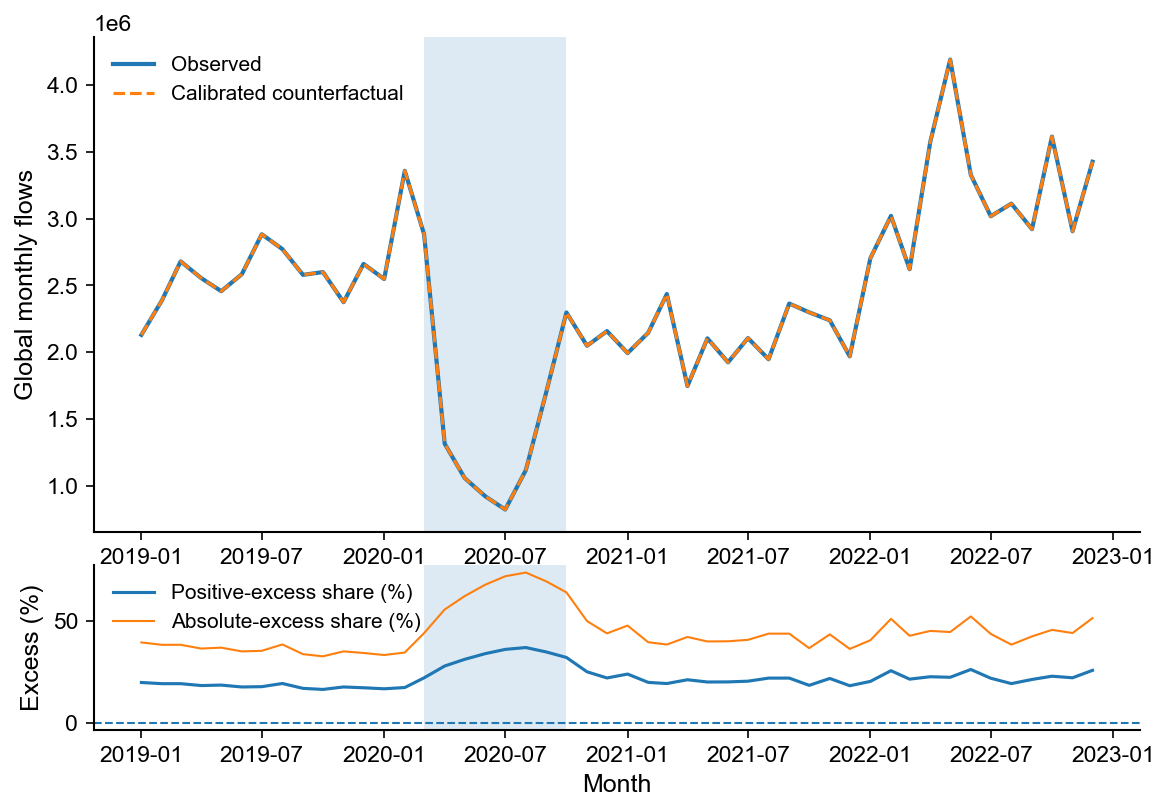

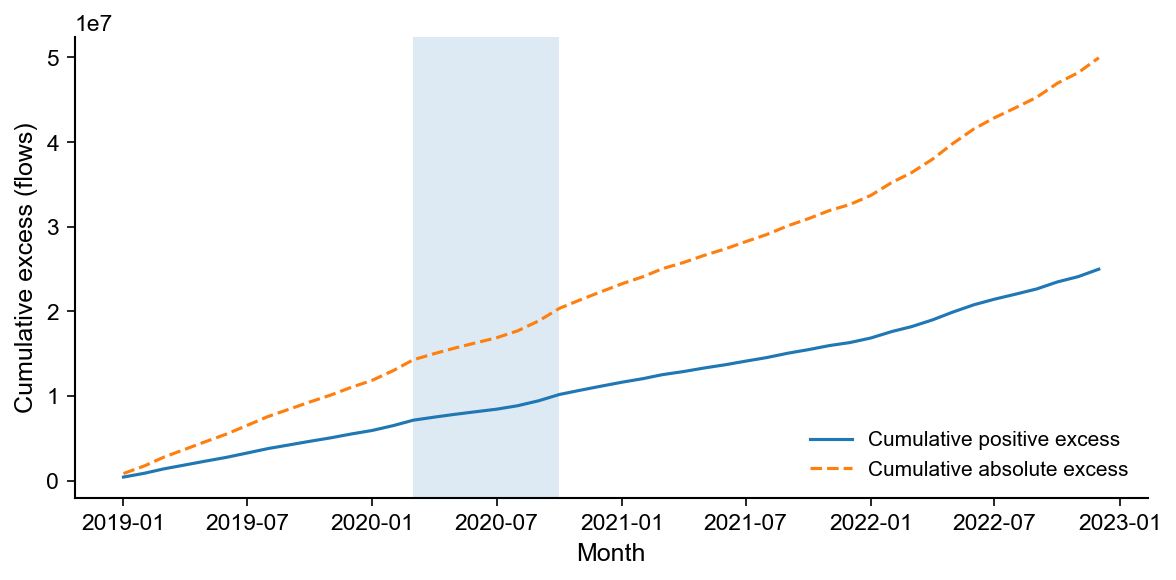

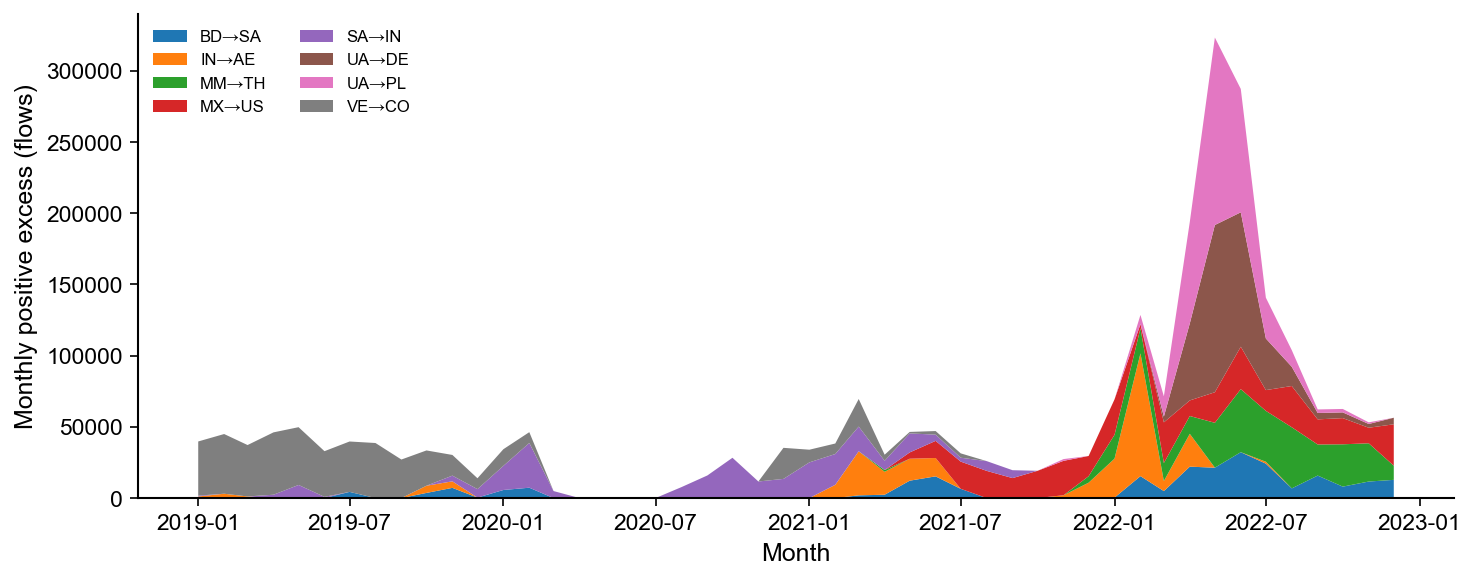

In [8]:
# 1) Build the calibrated frame and monthly aggregates
df_cal, G = build_global_series(pred)

# 2) Main two-panel global figure
plot_global_baseline_and_redistribution(G, covid_start="2020-03-01", covid_end="2020-10-01")

# 3) Optional extras
plot_cumulative_excess(G, covid_start="2020-03-01", covid_end="2020-10-01")
plot_topk_positive_excess(df_cal, k=8)


In [17]:
# import pandas as pd
# import numpy as np

# # ----- CONFIG -----
# COVID_START = pd.Timestamp("2020-03-01")
# COVID_END   = pd.Timestamp("2020-10-01")

# def _period_mask(G, start=None, end=None):
#     d = G["date"]
#     m = pd.Series(True, index=G.index)
#     if start is not None:
#         m &= d >= pd.Timestamp(start)
#     if end is not None:
#         m &= d <= pd.Timestamp(end)
#     return m

# def _pct(x):  # format as percentage with one decimal
#     return f"{100*x:.1f}%"

# def _mil(x):  # format counts in millions with one decimal
#     return f"{x/1e6:.1f}M"

# def compute_global_stats(G, covid_start=COVID_START, covid_end=COVID_END):
#     """Return a dict of key stats for text/captions."""
#     G = G.copy()
#     # ensure datetime
#     G["date"] = pd.to_datetime(G["date"])

#     # PERIODS
#     m_all   = _period_mask(G)
#     m_pre   = _period_mask(G, end=covid_start - pd.offsets.MonthBegin(0))
#     m_covid = _period_mask(G, start=covid_start, end=covid_end)
#     m_post  = _period_mask(G, start=covid_end + pd.offsets.MonthBegin(0))

#     # SHARES (means & peaks)
#     def share_stats(mask, col):
#         s = G.loc[mask, col].dropna()
#         if s.empty:
#             return {"mean": np.nan, "median": np.nan, "max": (np.nan, None)}
#         idxmax = s.idxmax()
#         return {
#             "mean": s.mean(),
#             "median": s.median(),
#             "max": (s.loc[idxmax], G.loc[idxmax, "date"])
#         }

#     pos_all   = share_stats(m_all,   "pos_excess_share")
#     pos_pre   = share_stats(m_pre,   "pos_excess_share")
#     pos_covid = share_stats(m_covid, "pos_excess_share")
#     pos_post  = share_stats(m_post,  "pos_excess_share")

#     abs_all   = share_stats(m_all,   "abs_excess_share")
#     abs_pre   = share_stats(m_pre,   "abs_excess_share")
#     abs_covid = share_stats(m_covid, "abs_excess_share")
#     abs_post  = share_stats(m_post,  "abs_excess_share")

#     # CUMULATIVES at period ends
#     # (cum_* already accumulate over the whole series; to get period totals, sum monthly)
#     tot_pos_all   = G.loc[m_all,   "pos"].sum()
#     tot_abs_all   = G.loc[m_all,   "ab"].sum()
#     tot_pos_pre   = G.loc[m_pre,   "pos"].sum()
#     tot_abs_pre   = G.loc[m_pre,   "ab"].sum()
#     tot_pos_covid = G.loc[m_covid, "pos"].sum()
#     tot_abs_covid = G.loc[m_covid, "ab"].sum()
#     tot_pos_post  = G.loc[m_post,  "pos"].sum()
#     tot_abs_post  = G.loc[m_post,  "ab"].sum()

#     # OPTIONAL: typical monthly global baseline size (for context)
#     mean_baseline_all = G.loc[m_all, "hat_cal"].mean()

#     return {
#         "periods": {
#             "pre":   (G.loc[m_pre, "date"].min(),   G.loc[m_pre, "date"].max()),
#             "covid": (G.loc[m_covid, "date"].min(), G.loc[m_covid, "date"].max()),
#             "post":  (G.loc[m_post, "date"].min(),  G.loc[m_post, "date"].max()),
#         },
#         "pos_share": {
#             "all":   pos_all,
#             "pre":   pos_pre,
#             "covid": pos_covid,
#             "post":  pos_post,
#         },
#         "abs_share": {
#             "all":   abs_all,
#             "pre":   abs_pre,
#             "covid": abs_covid,
#             "post":  abs_post,
#         },
#         "totals": {
#             "pos":  {"all": tot_pos_all, "pre": tot_pos_pre, "covid": tot_pos_covid, "post": tot_pos_post},
#             "abs":  {"all": tot_abs_all, "pre": tot_abs_pre, "covid": tot_abs_covid, "post": tot_abs_post},
#         },
#         "context": {"mean_monthly_baseline": mean_baseline_all},
#     }

# # Pretty-print a short summary (for your paper text)
# def print_global_stats(stats):
#     pos_all = stats["pos_share"]["all"]; abs_all = stats["abs_share"]["all"]
#     pos_covid = stats["pos_share"]["covid"]; abs_covid = stats["abs_share"]["covid"]

#     print("=== Global redistribution metrics ===")
#     print(f"Average positive-excess share: {_pct(pos_all['mean'])} (median {_pct(pos_all['median'])}); "
#           f"peak {_pct(pos_all['max'][0])} in {pos_all['max'][1].date() if pos_all['max'][1] else 'NA'}")
#     print(f"Average absolute-excess share: {_pct(abs_all['mean'])} (median {_pct(abs_all['median'])}); "
#           f"peak {_pct(abs_all['max'][0])} in {abs_all['max'][1].date() if abs_all['max'][1] else 'NA'}")

#     print("\n— COVID window —")
#     print(f"Positive-excess share (mean): {_pct(pos_covid['mean'])}; peak {_pct(pos_covid['max'][0])} "
#           f"in {pos_covid['max'][1].date() if pos_covid['max'][1] else 'NA'}")
#     print(f"Absolute-excess share (mean): {_pct(abs_covid['mean'])}; peak {_pct(abs_covid['max'][0])} "
#           f"in {abs_covid['max'][1].date() if abs_covid['max'][1] else 'NA'}")

#     print("\nCumulative totals (flows):")
#     print(f"  Positive-excess: {_mil(stats['totals']['pos']['all'])} "
#           f"(pre {_mil(stats['totals']['pos']['pre'])}, covid {_mil(stats['totals']['pos']['covid'])}, "
#           f"post {_mil(stats['totals']['pos']['post'])})")
#     print(f"  Absolute-excess: {_mil(stats['totals']['abs']['all'])} "
#           f"(pre {_mil(stats['totals']['abs']['pre'])}, covid {_mil(stats['totals']['abs']['covid'])}, "
#           f"post {_mil(stats['totals']['abs']['post'])})")

#     print(f"\nContext: mean monthly global baseline size ≈ {_mil(stats['context']['mean_monthly_baseline'])}")



=== Global redistribution metrics ===
Average positive-excess share: 22.2% (median 21.1%); peak 36.8% in 2020-08-01
Average absolute-excess share: 44.4% (median 42.1%); peak 73.6% in 2020-08-01

— COVID window —
Positive-excess share (mean): 31.7%; peak 36.8% in 2020-08-01
Absolute-excess share (mean): 63.4%; peak 73.6% in 2020-08-01

Cumulative totals (flows):
  Positive-excess: 25.0M (pre 7.1M, covid 3.7M, post 15.5M)
  Absolute-excess: 50.0M (pre 14.3M, covid 7.3M, post 31.1M)

Context: mean monthly global baseline size ≈ 2.4M


In [11]:
from CF_result import (compute_global_stats, 
        print_global_stats)
# ---- RUN ----
stats = compute_global_stats(G)     # uses your G from earlier
print_global_stats(stats)
# stats

=== Global redistribution metrics ===
Average positive-excess share: 22.2% (median 21.1%); peak 36.8% in 2020-08-01
Average absolute-excess share: 44.4% (median 42.1%); peak 73.6% in 2020-08-01

— COVID window —
Positive-excess share (mean): 31.7%; peak 36.8% in 2020-08-01
Absolute-excess share (mean): 63.4%; peak 73.6% in 2020-08-01

Cumulative totals (flows):
  Positive-excess: 25.0M (pre 7.1M, covid 3.7M, post 15.5M)
  Absolute-excess: 50.0M (pre 14.3M, covid 7.3M, post 31.1M)

Context: mean monthly global baseline size ≈ 2.4M


In [18]:
# import numpy as np
# import pandas as pd

# def _safe_mape(y, yhat):
#     y = np.asarray(y, dtype=float)
#     yhat = np.asarray(yhat, dtype=float)
#     mask = y != 0
#     if not np.any(mask): 
#         return np.nan
#     return np.mean(np.abs((y[mask]-yhat[mask]) / y[mask]))

# def _smape(y, yhat):
#     y = np.asarray(y, dtype=float)
#     yhat = np.asarray(yhat, dtype=float)
#     denom = (np.abs(y) + np.abs(yhat))
#     mask = denom != 0
#     if not np.any(mask):
#         return np.nan
#     return np.mean(2.0 * np.abs(y[mask]-yhat[mask]) / denom[mask])

# def _ccc(y, yhat):
#     # Lin's concordance correlation coefficient
#     y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
#     mu_y, mu_h = np.mean(y), np.mean(yhat)
#     s2_y, s2_h = np.var(y, ddof=1), np.var(yhat, ddof=1)
#     cov = np.cov(y, yhat, ddof=1)[0,1]
#     return (2*cov) / (s2_y + s2_h + (mu_y - mu_h)**2) if (s2_y + s2_h + (mu_y - mu_h)**2)!=0 else np.nan

# def _nse(y, yhat):
#     y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
#     denom = np.sum((y - np.mean(y))**2)
#     if denom == 0: 
#         return np.nan
#     return 1.0 - np.sum((y - yhat)**2) / denom

# def _theil_u2(y, yhat):
#     # Compare model errors to naive (y_{t-1})
#     y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
#     if len(y) < 2:
#         return np.nan
#     err_model = y[1:] - yhat[1:]
#     err_naive = y[1:] - y[:-1]
#     denom = np.sqrt(np.mean(err_naive**2))
#     return np.sqrt(np.mean(err_model**2)) / denom if denom != 0 else np.nan

# def _diff_corr(y, yhat):
#     y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
#     if len(y) < 2:
#         return np.nan
#     dy, dh = np.diff(y), np.diff(yhat)
#     if np.std(dy)==0 or np.std(dh)==0:
#         return np.nan
#     return np.corrcoef(dy, dh)[0,1]

# def _series_metrics(y, yhat):
#     y = np.asarray(y, dtype=float); yhat = np.asarray(yhat, dtype=float)
#     rmse = np.sqrt(np.mean((y - yhat)**2))
#     nrmse_mean = rmse / (np.mean(y) if np.mean(y)!=0 else np.nan)
#     y_range = np.max(y) - np.min(y)
#     nrmse_range = rmse / (y_range if y_range!=0 else np.nan)
#     r = np.corrcoef(y, yhat)[0,1] if np.std(y)>0 and np.std(yhat)>0 else np.nan
#     return {
#         "NSE(R2_1to1)": _nse(y, yhat),
#         "RMSE": rmse,
#         "NRMSE_mean": nrmse_mean,
#         "NRMSE_range": nrmse_range,
#         "MAPE": _safe_mape(y, yhat),
#         "sMAPE": _smape(y, yhat),
#         "Pearson_r": r,
#         "CCC": _ccc(y, yhat),
#         "Delta_corr": _diff_corr(y, yhat),
#         "Theil_U2_vs_naive": _theil_u2(y, yhat),
#     }

# def metrics_for_global(df_cal):
#     g = (df_cal.groupby("month", as_index=False)
#                  .agg(flow=("flow","sum"), hat=("mu_hat_cal","sum"))
#                  .sort_values("month"))
#     return pd.Series(_series_metrics(g["flow"].values, g["hat"].values), name="GLOBAL")

# def metrics_for_corridors(df_cal, corridors):
#     """
#     corridors: list of (orig, dest) tuples, e.g. [('FR','DE'), ('CA','US')]
#     Returns a DataFrame with one row per corridor that exists in the data.
#     """
#     rows = []
#     for o,d in corridors:
#         sub = (df_cal[(df_cal["orig"]==o) & (df_cal["dest"]==d)]
#                       .sort_values("month")[["month","flow","mu_hat_cal"]])
#         if len(sub) == 0:
#             rows.append(pd.Series({"orig":o,"dest":d,"note":"no data"}, name=f"{o}->{d}"))
#             continue
#         m = _series_metrics(sub["flow"].values, sub["mu_hat_cal"].values)
#         s = pd.Series(m, name=f"{o}->{d}")
#         s["orig"], s["dest"] = o, d
#         rows.append(s)
#     return pd.DataFrame(rows)

NSE(R2_1to1)         1.000000e+00
RMSE                 1.680310e-10
NRMSE_mean           6.917794e-17
NRMSE_range          4.989257e-17
MAPE                 2.316682e-17
sMAPE                2.316682e-17
Pearson_r            1.000000e+00
CCC                  1.000000e+00
Delta_corr           1.000000e+00
Theil_U2_vs_naive    3.667273e-16
Name: GLOBAL, dtype: float64
        NSE(R2_1to1)         RMSE  NRMSE_mean  NRMSE_range      MAPE  \
FR->DE     -0.007939   288.173636    0.330395     0.197650  0.261396   
CA->US      0.414593  1058.585433    0.254599     0.158637  0.183892   

           sMAPE  Pearson_r       CCC  Delta_corr  Theil_U2_vs_naive orig dest  
FR->DE  0.249510   0.430587  0.426465    0.663465           1.054679   FR   DE  
CA->US  0.181528   0.671121  0.663600    0.637808           0.998858   CA   US  


In [12]:
from CF_result import (metrics_for_global, 
        metrics_for_corridors)

# ------- EXAMPLE USAGE -------
# GLOBAL metrics:
global_metrics = metrics_for_global(df_cal)
global_metrics

NSE(R2_1to1)         1.000000e+00
RMSE                 1.680310e-10
NRMSE_mean           6.917794e-17
NRMSE_range          4.989257e-17
MAPE                 2.316682e-17
sMAPE                2.316682e-17
Pearson_r            1.000000e+00
CCC                  1.000000e+00
Delta_corr           1.000000e+00
Theil_U2_vs_naive    3.667273e-16
Name: GLOBAL, dtype: float64

In [13]:
# Corridor metrics (examples):
corr_set = [('FR','DE'), ('CA','US')]
corr_metrics = metrics_for_corridors(df_cal, corr_set)
corr_metrics

,NSE(R2_1to1),RMSE,NRMSE_mean,NRMSE_range,MAPE,sMAPE,Pearson_r,CCC,Delta_corr,Theil_U2_vs_naive,orig,dest
FR->DE,-0.007939,288.173636,0.330395,0.197650,0.261396,0.249510,0.430587,0.426465,0.663465,1.054679,FR,DE
CA->US,0.414593,1058.585433,0.254599,0.158637,0.183892,0.181528,0.671121,0.663600,0.637808,0.998858,CA,US


### Single

In [6]:
pred = pred_ALL

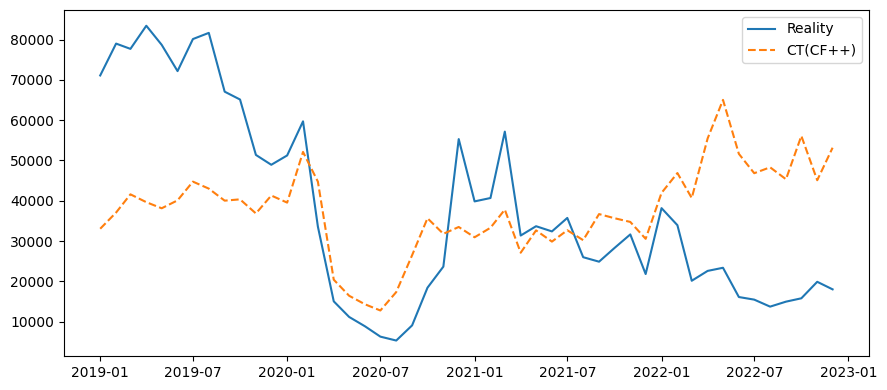

In [22]:
sub = pred[(pred.orig=="VE")&(pred.dest=="CO")].sort_values("month")
# sub = pred[(pred.orig=="DE")&(pred.dest=="FR")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

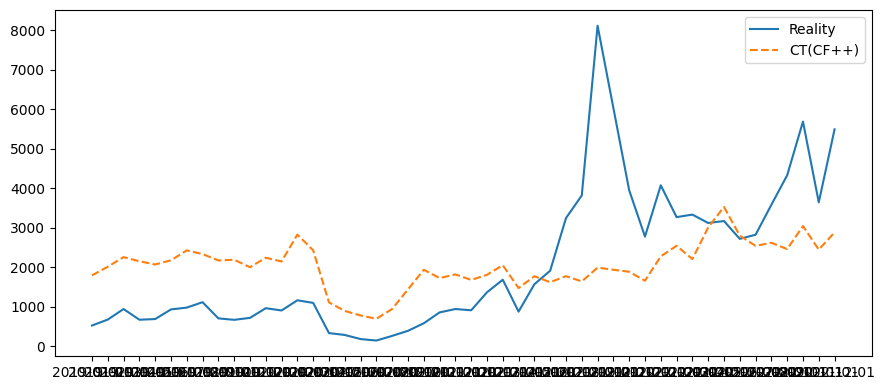

In [8]:
import matplotlib.pyplot as plt

sub = pred[(pred.orig=="CL")&(pred.dest=="US")].sort_values("month")
plt.figure(figsize=(9,4))
plt.plot(sub["month"], sub["flow"], label="Reality")
plt.plot(sub["month"], sub["mu_hat"], label="CT(CF++)", linestyle="--")
plt.legend(); plt.tight_layout(); plt.show()

In [9]:
from plot_triad import plot_pair_actual_vs_counterfactual

In [10]:
policies_CL = [
    ("2021-04-01", "Ley 21325 \nApril 2021", "red"),
    ("2021-03-01", "US Policy", "yellow")
]

policies_PE = [
    ("2019-07-15", "Visa Requirement\nJune 2019", "Red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2021-07-01", "Temporary Permit Carnet (CPT)\nJuly 2021", "green"),
    ("2021-10-22", "CPT Implementation\nOctober 2021", "red")
]

policies_EC = [
    ("2019-07-25", "Presidential Decree 826\nJuly 2019", "red"),
    ("2021-03-01", "US Policy", "yellow"),
    ("2019-08-26", "VIRTE\nBefore July 2019", "blue"),
    ("2022-06-01", "VIRTE\nSep 2022 to Aug 2023", "blue")
]

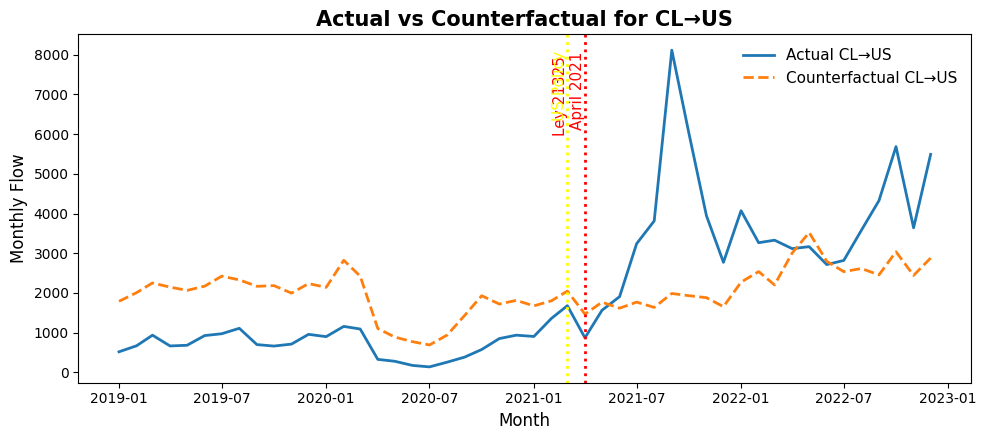

In [11]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="CL", dest="US",  
    policies=policies_CL,
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)

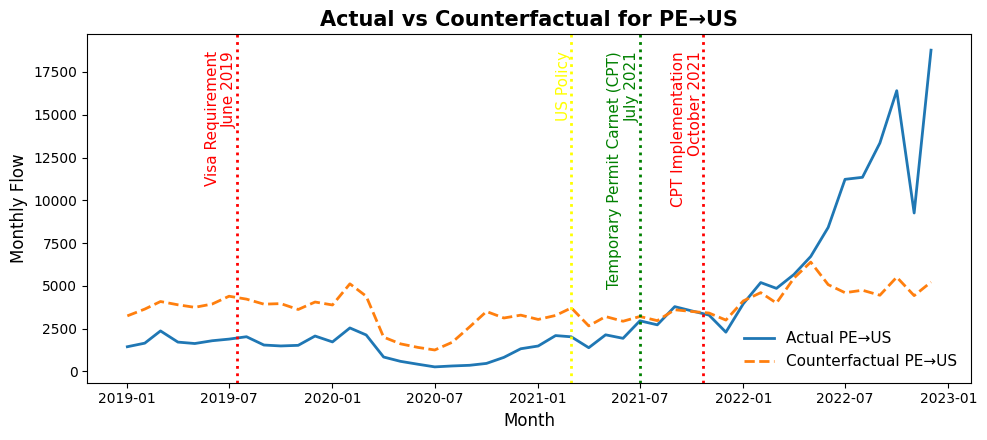

In [12]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="PE", dest="US", 
    policies=policies_PE,
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)

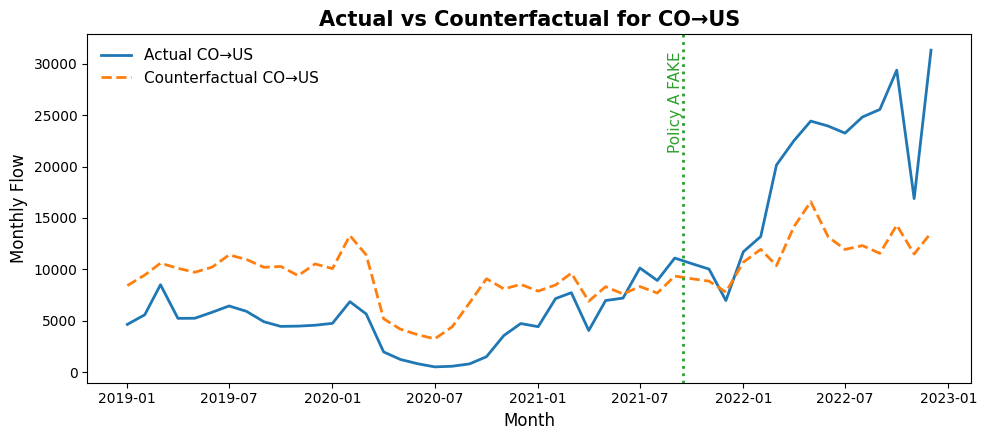

In [13]:
plot_pair_actual_vs_counterfactual(
    pred,
    orig="CO", dest="US", 
    policies=[("2021-09-15","Policy A FAKE","tab:green")],
    line_colors={"actual":"tab:blue", "counterfactual":"tab:orange"},
    yscale="linear"
)